In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset

import torchvision
from torchvision.io import read_image
from torchvision.utils import make_grid
from torchvision import transforms

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from collections import defaultdict

from datasets import *
from styleExtraction import *
from DDPM import trainDDPM


def displayImageGrid(images: list, H: int, W: int=0, labels: list=None, figsize=None, title=''):
    """
    Display list of images in a grid (H, W) without boundaries. The images MUST be the same size or this will probably look weird.

    Arguments:
        images: List of numpy arrays representing the images. The images should be the same size
        H: Number of rows.
        W: Number of columns.
        figsize: The figure size of the output plot
        title: A title for the plot
    """
    
    numImages = len(images)
    
    # If no width is defined, we assume a single row of images
    if W == 0:
        W = numImages
    
    if numImages < H * W:
        raise ValueError(f"Number of images ({len(images)}) is smaller than given grid size!")
    
    # Shrink figure size if plotting lots of images
    if figsize is None:
        fig = plt.figure(figsize=(W/5, H/5))
    else:
        fig = plt.figure(figsize=figsize)

    for i in range(H * W):
        img = images[i]
        label = labels[i] if labels is not None else ''
            
        ax = fig.add_subplot(H, W, i+1)
        ax.imshow(img, cmap='gray')

        # Remove axis details
        ax.axis('off')
        
        # Adjust the position of the axis for each image slightly to make room for the label
        # ax.set_position([i%W/W, 1-(i//W+1)/H + 0.2, 1/W, 1/H - 0.05])
        
        # Adjust the position of the axis for each image to make more room for the label
        ax.set_position([i%W/W, 1-(i//W+1)/H + 0.05, 1/W, 1/H - 2])
        
        # Add label below the image
        ax.set_title(label, fontsize=10, pad=6, y=-0.25) # pad adds space between the image and the label
        
        # Add label below the image
        # ax.set_title(label, fontsize=10, y=-0.2)
        

    plt.suptitle(title)
    plt.subplots_adjust(wspace=0, hspace=0, top=0.95)
    plt.show()



def visualizeSamples(dataLoader: DataLoader, BATCH_SIZE=64, H=8, W=8, title=''):
    
    features, labels = next(iter(dataLoader))
    features: torch.Tensor
    labels: torch.Tensor

    # Do the tensor shuffle
    featuresArray = features.numpy().transpose(2, 3, 1, 0)
    labelsList = list(labels.numpy())
    labelsList = [EMNISTDataset.intToStrDict[l] for l in labelsList]

    displayImageGrid([featuresArray[..., idx] for idx in range(BATCH_SIZE)], H=H, W=W, figsize=(10, 12), title=title, labels=labelsList)
    


In [3]:
# Keep this to visualize raw .csv data if needed
# num_columns = 785
# # Create column names
# columns = ['label'] + list(range(1, num_columns))
# # Read the training and testing datasets
# ds_train = pd.read_csv("Data\EMNIST\EMNIST\emnist-letters-train.csv", header=None)
# ds_test = pd.read_csv("Data\EMNIST\EMNIST\emnist-letters-test.csv", header=None)
# # Assign column names to the DataFrames
# ds_train.columns = columns
# ds_test.columns = columns
# # Reset index
# ds_train = ds_train.reset_index(drop=True)
# ds_test = ds_test.reset_index(drop=True)
# # Extract features and labels
# x_train = ds_train.drop(['label'], axis=1)
# y_train = ds_train['label']
# x_test = ds_test.drop(['label'], axis=1)
# y_test = ds_test['label']
# # Display the first few rows of the DataFrame
# print(ds_train.head())
# print(ds_test.head())
# print(sorted(ds_train['label'].unique()))

In [4]:
trainset = getFullDataset()

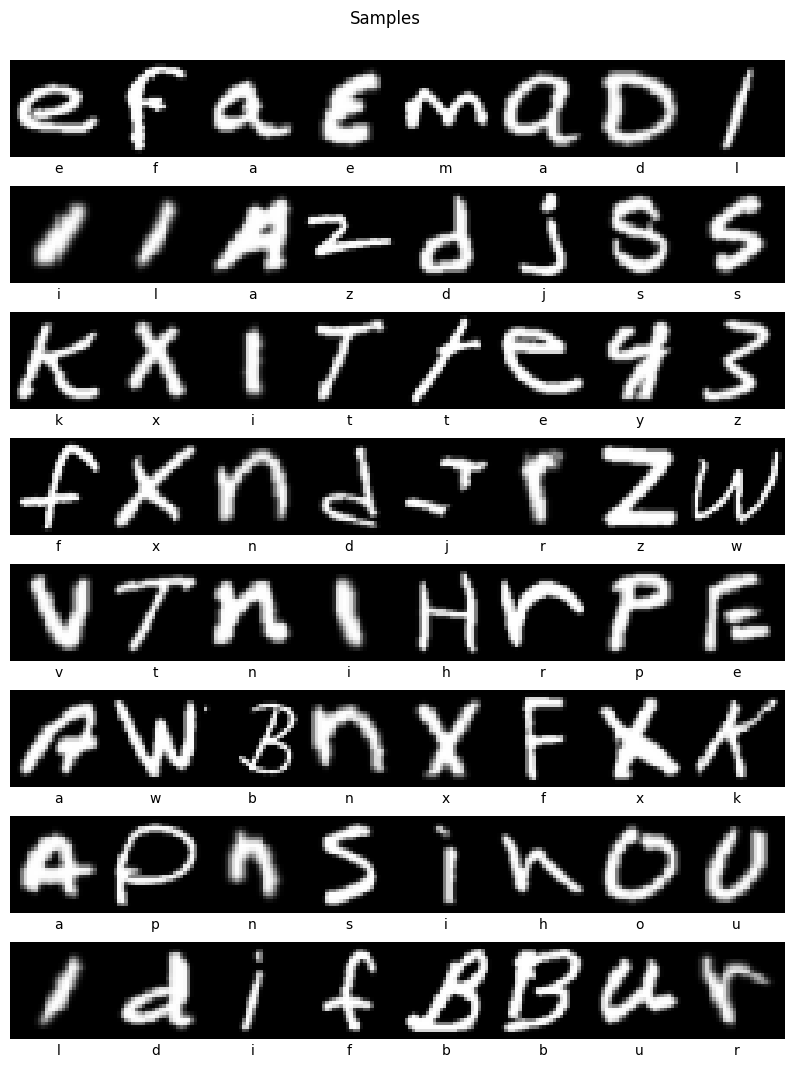

In [5]:
BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

features, labels = next(iter(trainloader))
features = features.clone().detach()

visualizeSamples(trainloader, title='Samples')

# Perform PCA and clustering to isolate handwriting "styles"

This works somewhat, but when clustering on the entire alphabet, we don't get very isolated styles per letter.

[28686 30991 22899 21024]


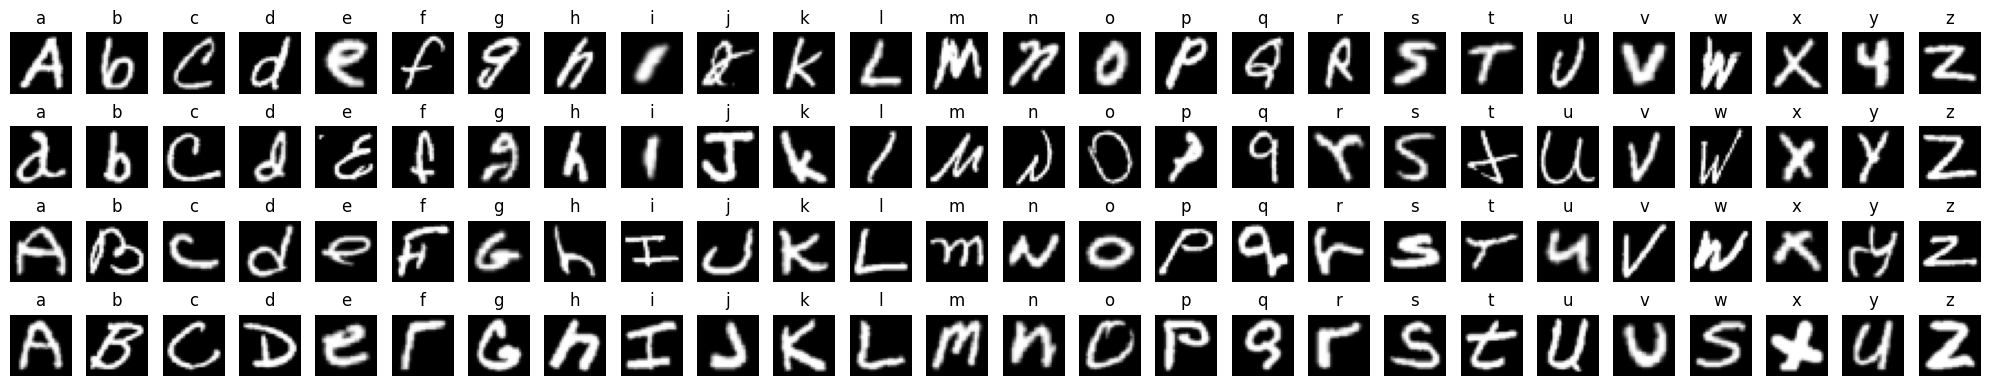

In [6]:
# Cluster the data points
numClusters = 4

# Flatten the images
flatImages = trainset.images.reshape(len(trainset), -1).numpy()

# Perform PCA
pca = PCA(n_components=500)
features = pca.fit_transform(flatImages)

# ISOMAP is VERY slow for large datasets
# isomap = Isomap(n_components=30, n_jobs=-1, n_neighbors=20)
# features = isomap.fit_transform(flatImages)


kmeans = KMeans(n_clusters=numClusters)
clusterLabels = kmeans.fit_predict(features)


minLettersPerCluster = 1000 

# Count the number of letters in each cluster
clusterCounts = np.bincount(clusterLabels)
print(clusterCounts)

# Identify clusters with insufficient letters
smallClusters = np.where(clusterCounts < minLettersPerCluster)[0]

# Merge small clusters with the nearest larger clusters
for smallCluster in smallClusters:
    
    # Find the nearest larger cluster
    nearestCluster = None
    minDistance = float('inf')
    for cluster in range(numClusters):
        if cluster != smallCluster and clusterCounts[cluster] >= minLettersPerCluster:
            distance = np.linalg.norm(kmeans.cluster_centers_[smallCluster] - kmeans.cluster_centers_[cluster])
            if distance < minDistance:
                minDistance = distance
                nearestCluster = cluster
    
    # Merge the small cluster with the nearest larger cluster
    clusterLabels[clusterLabels == smallCluster] = nearestCluster


# Visualize the clusters
fig, axs = plt.subplots(numClusters, 26, figsize=(20, numClusters))
for i in range(numClusters):
    originalIndices = np.where(clusterLabels == i)[0]
    for j in range(26):
        letterIndices = np.where(trainset.labels[originalIndices] == j+1)[0]
        if len(letterIndices) > 0:
            imageIndex = originalIndices[np.random.choice(letterIndices)]
            axs[i, j].imshow(trainset.images[imageIndex].squeeze(), cmap='gray')
            axs[i, j].set_title(trainset.intToStrDict[j+1])
            axs[i, j].axis('off')
        else:
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

# Cluster on individual PCA letters instead of clustering on the entire dataset
### This should let us choose individual letters to include in a handwriting style

Letter a cluster counts:
[358, 292, 397, 317, 404, 472, 410, 315, 272, 267, 305, 387]


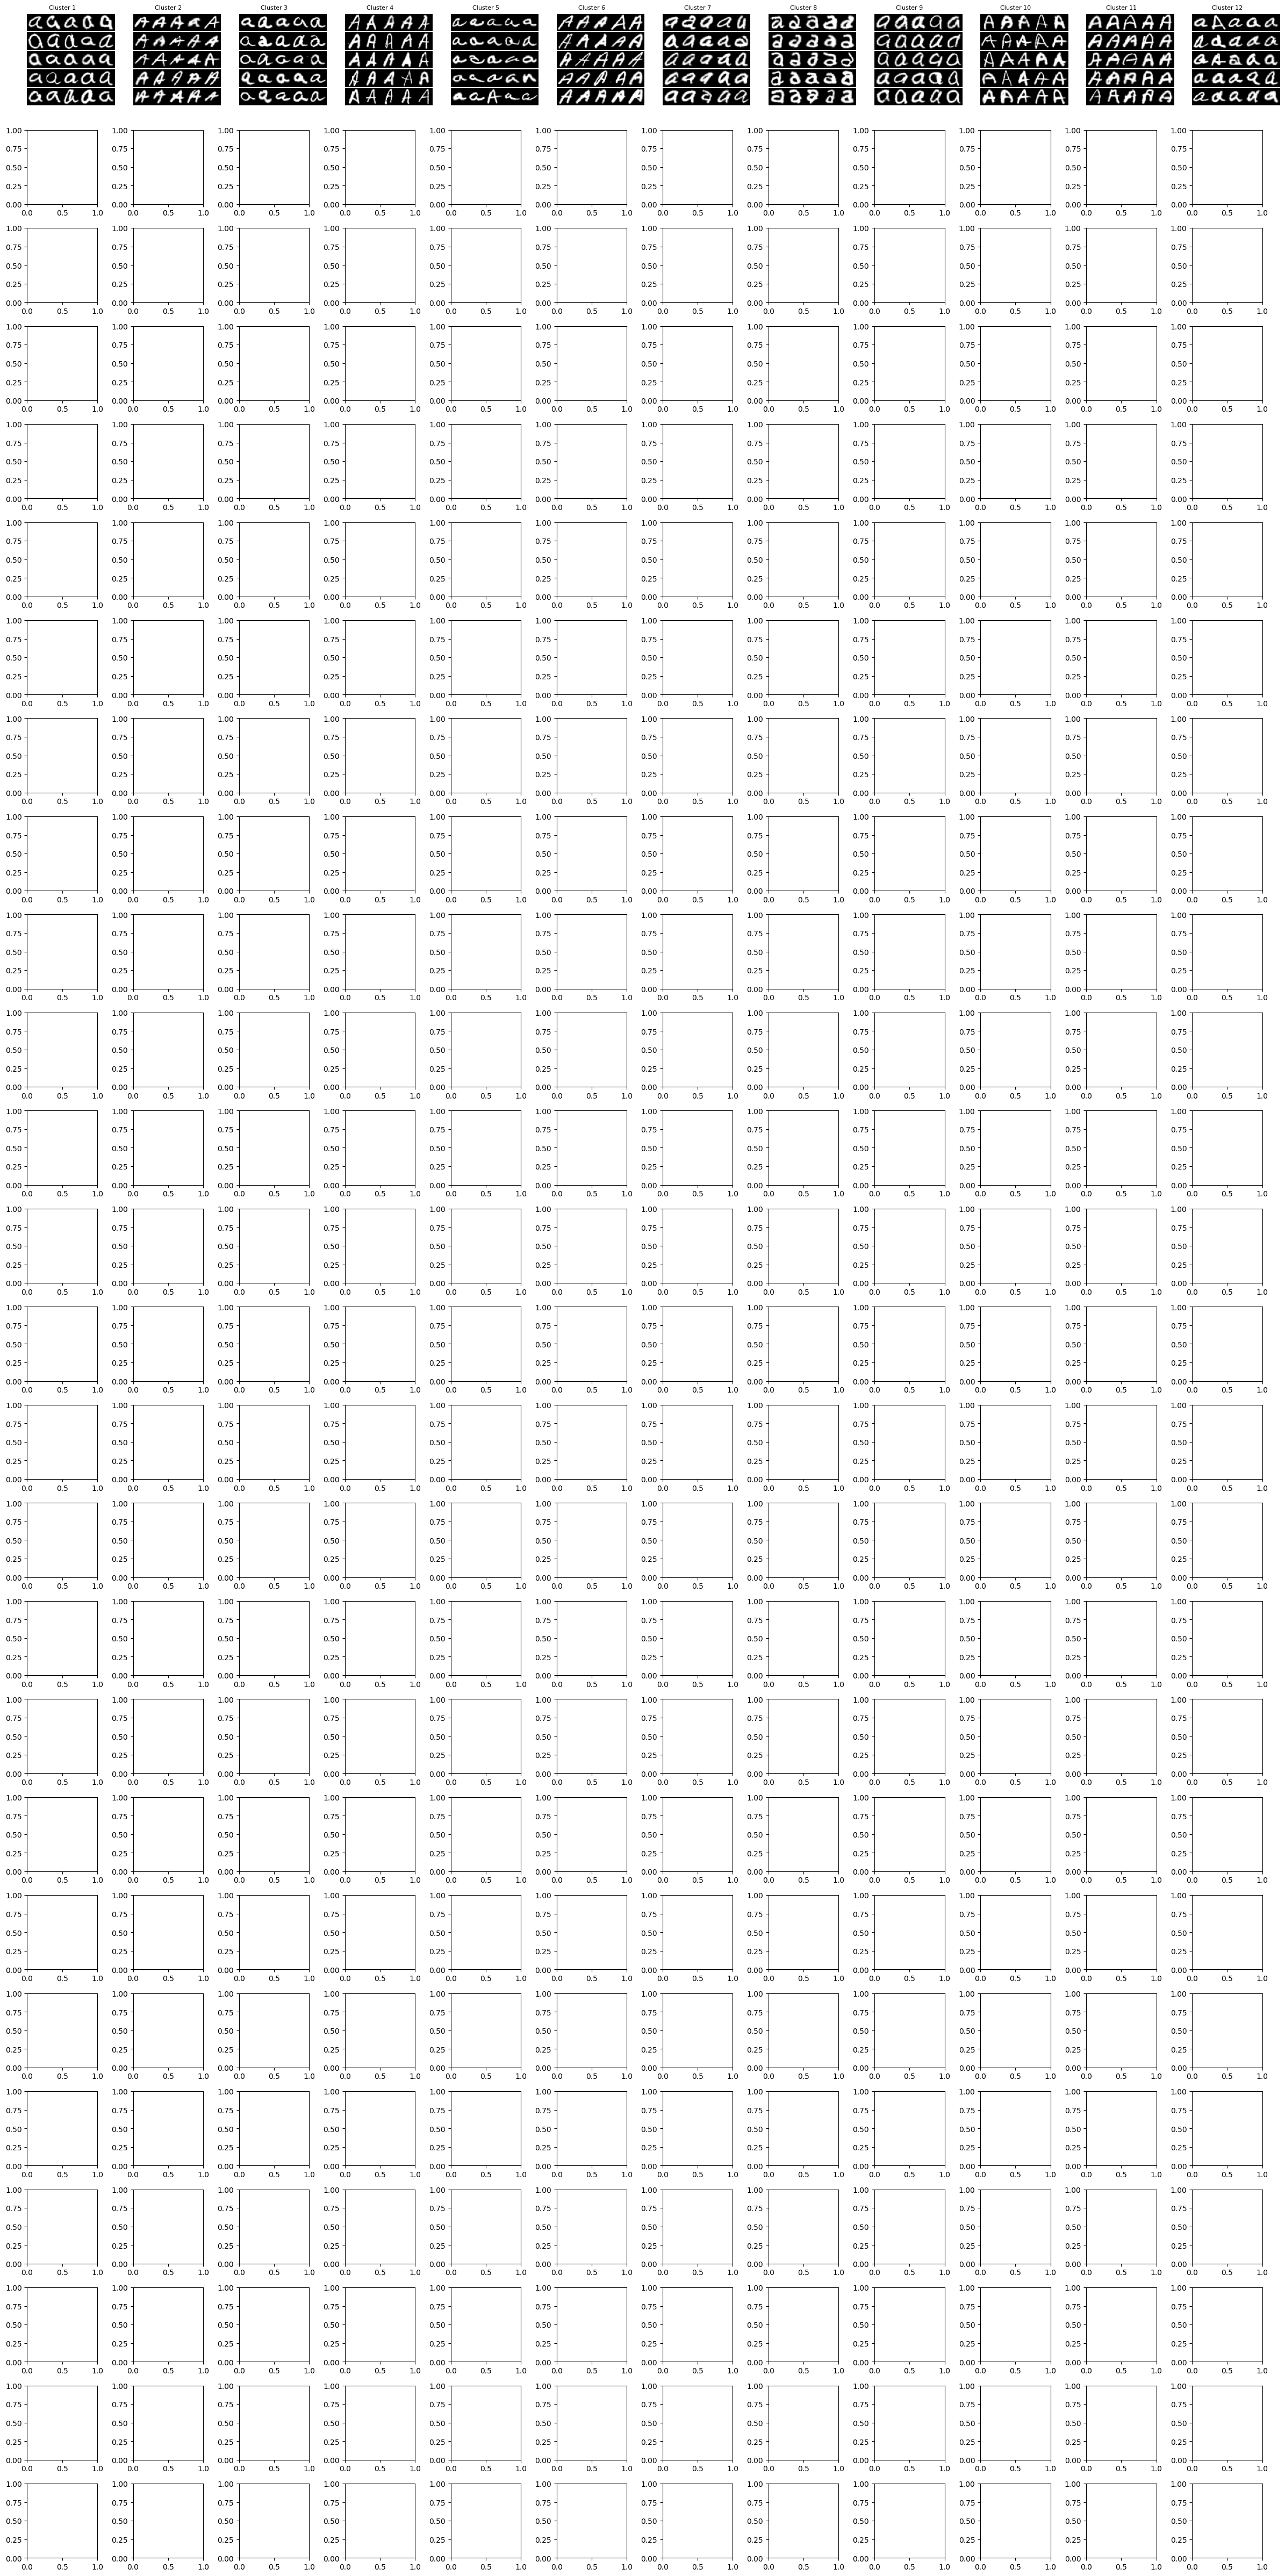

In [7]:
CLUSTER_DATA = getClusterDataForLetters(trainset=trainset, showPlots=True, numClasses=1)


In [8]:
subsets = createSubsets(trainset, CLUSTER_DATA)
letterASubset = subsets[1]

clusterImages = []

for clusterNum in range(len(CLUSTER_DATA[1])):
    currentFeatures = letterASubset.features[letterASubset.labels == clusterNum]
    grid = make_grid(currentFeatures, nrow=int(np.sqrt(currentFeatures.shape[0])), normalize=True)
    
    t = transforms.Compose([
        transforms.Resize((512, 512))
    ])
    clusterImages.append(torch.mean(t(grid), dim=0))


fullImage = torch.stack(clusterImages, dim=0).unsqueeze(1)
newGrid = make_grid(fullImage, nrow=len(clusterImages)//2, normalize=True)
img = torchvision.transforms.ToPILImage()(newGrid)
img.show()